# Run training script in local notebook
# Original notebook
- https://github.com/aws-samples/amazon-sagemaker-script-mode/blob/master/tf-sentiment-script-mode/sentiment-analysis.ipynb

## Modified Points:
- This notebook is tested in SageMaker Studio with kernel Python3 (Tensorflow2 GPU Optimized)
- Create training script sentiment-gs.py that is mostly similar to the original version, sentiment.py
- Run sentiment-gs.py on notebook

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

### Set working folder

In [2]:
import os
os.chdir('/root/tensorflow-sagemaker-examples/tf-sentiment-script-mode')
os.getcwd()

'/root/tensorflow-sagemaker-examples/tf-sentiment-script-mode'

### Download data

In [3]:
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import numpy as np
import os

from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras.datasets import imdb

max_features = 20000
maxlen = 400

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

25000 train sequences
25000 test sequences
x_train shape: (25000, 400)
x_test shape: (25000, 400)


### Store file into the folder

In [4]:
data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)

csv_test_dir = os.path.join(os.getcwd(), 'data/csv-test')
os.makedirs(csv_test_dir, exist_ok=True)

np.save(os.path.join(train_dir, 'x_train.npy'), x_train)
np.save(os.path.join(train_dir, 'y_train.npy'), y_train)
np.save(os.path.join(test_dir, 'x_test.npy'), x_test)
np.save(os.path.join(test_dir, 'y_test.npy'), y_test)
np.savetxt(os.path.join(csv_test_dir, 'csv-test.csv'), np.array(x_test[:100], dtype=np.int32), fmt='%d', delimiter=",")

In [5]:
print("train_dir", train_dir)
print("test_dir", test_dir)

train_dir /root/tensorflow-sagemaker-examples/tf-sentiment-script-mode/data/train
test_dir /root/tensorflow-sagemaker-examples/tf-sentiment-script-mode/data/test


In [6]:
! mkdir model

### Write training script

In [7]:
%%writefile sentiment_gs.py

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import argparse
import codecs
import json
import numpy as np
import os
import tensorflow as tf

max_features = 20000
maxlen = 400
embedding_dims = 300
filters = 56
kernel_size = 3
hidden_dims = 56

def parse_args():
    
    parser = argparse.ArgumentParser()
    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type = int, default = 1)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--learning_rate', type=float, default=0.01)

    # data directories
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default = os.environ.get('SM_CHANNEL_TEST'))
    
    # model directory: we will use the default set by SageMaker, /opt/ml/model
    parser.add_argument('--model_dir', type=str, default = os.environ.get('SM_MODEL_DIR'))
    
    return parser.parse_known_args()

def save_history(path, history):

    history_for_json = {}
    # transform float values that aren't json-serializable
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            history_for_json[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float32 or type(history.history[key][0]) == np.float64:
               history_for_json[key] = list(map(float, history.history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history_for_json, f, separators=(',', ':'), sort_keys=True, indent=4) 

        
def get_train_data(train_dir):
    x_train = np.load(os.path.join(train_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(train_dir, 'y_train.npy'))
    print('x train', x_train.shape,'y train', y_train.shape)

    return x_train, y_train

def get_test_data(test_dir):

    x_test = np.load(os.path.join(test_dir, 'x_test.npy'))
    y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
    print('x test', x_test.shape,'y test', y_test.shape)

    return x_test, y_test

def get_model(learning_rate):
    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        embedding_layer = tf.keras.layers.Embedding(max_features,
                                                   embedding_dims,
                                                   input_length = maxlen)
        
        sequence_input = tf.keras.Input(shape=(maxlen,), dtype='int32')
        embedding_sequences = embedding_layer(sequence_input)
        x = tf.keras.layers.Dropout(0.2)(embedding_sequences)
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1)(x)
        x = tf.keras.layers.MaxPooling1D()(x)
        x = tf.keras.layers.GlobalMaxPooling1D()(x)
        x = tf.keras.layers.Dense(hidden_dims, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        preds = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        model = tf.keras.Model(sequence_input, preds)
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        model.compile(loss='binary_crossentropy',
                     optimizer = optimizer,
                     metrics = ['accuracy'])
        
        return model
    
    
if __name__ == "__main__":
    args, _ = parse_args()
    print("argument by gsmoon: ")
    print(args)
    
    x_train, y_train = get_train_data(args.train)
    x_test, y_test = get_test_data(args.test)
    
#     print("x_train: \n", x_train[0])
#     print("x_test: \n", x_test[0])    
    
    
    model = get_model(args.learning_rate)
    
    history = model.fit(x_train, y_train,
                       batch_size = args.batch_size,
                       epochs = args.epochs,
                       validation_data = (x_test, y_test))
    save_history(args.model_dir + "/history.p", history)    
    
    # create a tensorflow SavedModel for deployment to a SageMaker endpoint with Tensorflow Serving
    model.save(args.model_dir + '/1')    


Writing sentiment_gs.py


### Run script

In [8]:
! python sentiment_gs.py --train {train_dir} --test {test_dir} --batch_size 100 --epochs 10 --model_dir "model"

argument by gsmoon: 
Namespace(batch_size=100, epochs=10, learning_rate=0.01, model_dir='model', test='/root/tensorflow-sagemaker-examples/tf-sentiment-script-mode/data/test', train='/root/tensorflow-sagemaker-examples/tf-sentiment-script-mode/data/train')
x train (25000, 400) y train (25000,)
x test (25000, 400) y test (25000,)
2020-05-30 14:37:16.310194: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-30 14:37:16.849351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-30 14:37:16.850144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2020-05-30 14:37:16.850391: I tens

In [9]:
import json

with open('./model/history.p', "r") as f:
    history = json.load(f)
    


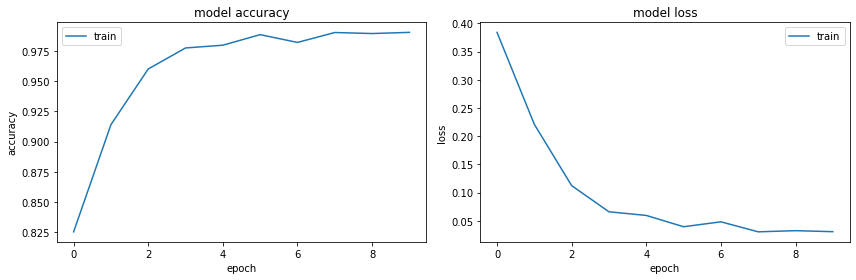

In [10]:
import matplotlib.pyplot as plt


def plot_training_curves(history): 
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['accuracy'], label='train')
    ax.set(title='model accuracy', ylabel='accuracy', xlabel='epoch')
    ax.legend()
    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.set(title='model loss', ylabel='loss', xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(history)    